<a href="https://colab.research.google.com/github/4LC4NT4R4/XMLD/blob/main/poo_xmld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
from datetime import datetime

!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Coleta de dados


In [9]:
class Spectrum():

    def __init__(self, x, y, pre=None, pos=None, E0=None, Ei=None, Ef=None, shift=None, n=1, m=1, flattering=True, name=None, legend=None):
        self.name = name
        self.legend = legend

        self._x = np.array(x)
        self._y = np.array(y)
        self._Ei=Ei #Cut the x,y data bellow Ei
        self._Ef=Ef #Cut the x,y data above Ef
        self._shift=shift #Energy shift
        self.dy_dx = np.gradient(y, x) #Derivative of y with repect to x
        self._E0 = E0 #Energy theshhold
        self._n=n
        self._m=m
        self._flattering=flattering
        self._pre = pre if pre is not None else [-90, -40]
        self._pos = pos if pos is not None else [31, 142]

        #Given after normalization
        self.f = None
        self.p = None

        self.cut_data()
        self.apply_shift()
        self.set_E0()

        self.norm_y = self.norm(self._x, self._y, self._E0, pre_edge=self._pre, pos_edge=self._pos, n=self._n, m=self._m, flattering=self._flattering)

    def cut_data(self):
        if self.Ei is not None:
            mask_Ei = self._x >= self.Ei
            self._x = self._x[mask_Ei]
            self._y = self._y[mask_Ei]
        if self.Ef is not None:
            mask_Ef = self._x <= self.Ef
            self._x = self._x[mask_Ef]
            self._y = self._y[mask_Ef]

    def apply_shift(self):
        if self.shift is not None:
            self._x += self.shift / 1000

    def set_E0(self):
        if self._E0 is None:
            self._E0 = self._x[np.argmax(self._y)]

    # Normalização de energia em eV
    def norm(self, x, y, e0, pre_edge, pos_edge, n=1, m=1, flattering=True):
        X = np.array(x, dtype='float')
        Y = np.array(y, dtype='float')

        # Pré-borda (pre-edge)
        mask_pre = (X >= e0 + (pre_edge[0] / 1000)) & (X <= e0 + (pre_edge[1] / 1000))
        x_pre = X[mask_pre]
        y_pre = Y[mask_pre]

        # Ajuste polinomial para a pré-borda
        coefficients_pre = np.polyfit(x_pre, y_pre, n)
        p = np.poly1d(coefficients_pre)
        self.p = p

        # Pós-borda (post-edge)
        mask_pos = (X >= e0 + (pos_edge[0] / 1000)) & (X <= e0 + (pos_edge[1] / 1000))
        x_pos = X[mask_pos]
        y_pos = Y[mask_pos]

        # Ajuste polinomial para a pós-borda
        coefficients_pos = np.polyfit(x_pos, y_pos, m)
        f = np.poly1d(coefficients_pos)
        self.f=f

        # Cálculo do edge step
        edge_step = f(e0) - p(e0)

        # Normalização
        if flattering:
            Y = Y - p(X) * (1 - np.heaviside(X - e0, 1))
            Y = Y + (edge_step - f(X)) * np.heaviside(X - e0, 1)
            Y = Y / edge_step
        else:
            Y = Y - p(X)
            Y = Y / edge_step

        return Y

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, x):
        self._x = np.array(x)
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def y(self):
        return self._y

    @y.setter
    def y(self, y):
        self._y = np.array(y)
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def E0(self):
        return self._E0

    @E0.setter
    def E0(self, E0):
        self._E0 = E0
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def Ei(self):
        return self._Ei

    @Ei.setter
    def Ei(self, Ei):
        self._Ei = Ei

    @property
    def Ef(self):
        return self._Ef

    @Ef.setter
    def Ef(self, Ef):
        self._Ef = Ef

    @property
    def shift(self):
        return self._shift

    @shift.setter
    def shift(self, shift):
        self._shift = shift

    @property
    def pre(self):
        return self._pre

    @pre.setter
    def pre(self, pre):
        self._pre = pre
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def pos(self):
        return self._pos

    @pos.setter
    def pos(self, pos):
        self._pos = pos
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        self._n = n
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)


    @property
    def m(self):
        return self._m

    @m.setter
    def m(self, m):
        self._m = m
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def flattering(self):
        return self._flattering

    @flattering.setter
    def flattering(self, flattering):
        self._flattering = flattering
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    def update_params(self, **kwargs):
        """
        Atualiza os parâmetros da classe e recalcula o espectro normalizado.
        """
        for key, value in kwargs.items():
            if hasattr(self, f"_{key}"):
                setattr(self, f"_{key}", value)
        self.norm_y = self.norm(self._x, self._y, self._E0, pre_edge=self._pre, pos_edge=self._pos, n=self._n, m=self._m, flattering=self._flattering)





    def plot_normalized(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.norm_y)
        plt.show()

    def plot_parameters(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.y)
        ax.plot(self.x,self.f(self.x))
        ax.plot(self.x,self.p(self.x))
        ax.axvline(x=self.E0+self.pre[0]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pre[1]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pos[0]/1000, color='g', linestyle='--')
        ax.axvline(x=self.E0+self.pos[1]/1000, color='g', linestyle='--')
        plt.show()






In [21]:
class Vortex:
    def __init__(self, path=None, roi=2, **spectrum_params):
        """
        Inicializa a classe Vortex. Pode-se fornecer um caminho para um arquivo CSV (path)
        ou quatro espectros (s1, s2, s3, s4) diretamente.
        """
        self.path = path
        self.roi = roi
        self._spectrum_params = spectrum_params

        # Atributos de metadados
        self.name = os.path.basename(path) if path else None
        self.date = '_'.join(self.path.split("_")[-2:]) if path else None
        self.legend = '_'.join(self.path.split("_")[1:4]) if path else None

        # Inicializar espectros
        self.s1 = spectrum_params.get('s1')
        self.s2 = spectrum_params.get('s2')
        self.s3 = spectrum_params.get('s3')
        self.s4 = spectrum_params.get('s4')

        # Carregar dados dos espectros
        if path:
            self.data = self._data(self.path)  # Carregar dados do arquivo
            if self.data is not None:
                self.s1 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}1'] / self.data['I0'], **self.spectrum_params)
                self.s2 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}2'] / self.data['I0'], **self.spectrum_params)
                self.s3 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}3'] / self.data['I0'], **self.spectrum_params)
                self.s4 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}4'] / self.data['I0'], **self.spectrum_params)

        # Lista de espectros
        self.spectra = [self.s1, self.s2, self.s3, self.s4]

        # Espectro somado
        if all(self.spectra):
            self.s = Spectrum(self.s1.x, self.s1.y + self.s2.y + self.s3.y + self.s4.y)
        else:
            self.s = None

    def _data(self, path, line_skip=9):
        """
        Método para carregar dados de um arquivo CSV.
        path: caminho para o arquivo
        line_skip: número de linhas a serem ignoradas no início do arquivo
        """
        try:
            with open(path, 'r') as arquivo_csv:
                reader_csv = csv.reader(arquivo_csv)
                m = 0
                df = None

                for line in reader_csv:
                    line = line[0].split()
                    if line[0] == '#L':  # Header line
                        col = line[1:]  # Remove '#L' e usa o restante como colunas
                        df = pd.DataFrame(columns=col)  # Cria um DataFrame vazio com essas colunas

                    if m >= line_skip and df is not None:  # Começa a ler dados após line_skip
                        df.loc[m - line_skip] = [float(item) for item in line]
                    m += 1
            return df

        except Exception as e:
            print(f"Erro ao carregar dados: {e}")
            return None

    @property
    def spectrum_params(self):
        return self._spectrum_params

    @spectrum_params.setter
    def spectrum_params(self, spectrum_params):
        self._spectrum_params = spectrum_params
        for spectrum in self.spectra:
                spectrum.update_params(**spectrum_params)


    def plot_derivative(self):
        """
        Plota as derivadas dos espectros s1, s2, s3 e s4.
        """
        fig, axs = plt.subplots()
        for i, spectrum in enumerate(self.spectra, start=1):
            if spectrum:
                axs.plot(spectrum.x, spectrum.dy_dx, marker=str(i), label=f'ROI{i}')
        axs.set_xlabel("Energy (eV)")
        axs.set_ylabel("dY/dX")
        axs.legend()
        plt.show()

    def plot_raw_data(self):
        """
        Plota os dados brutos (não normalizados) dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')
        titles = ['Gráfico 1', 'Gráfico 2', 'Gráfico 3', 'Gráfico 4']

        for i, spectrum in enumerate(self.spectra):
            if spectrum:
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.y, label=f'ROI{i+1}')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pre[0]/1000, color='r', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pre[1]/1000, color='r', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pos[0]/1000, color='g', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pos[1]/1000, color='g', linestyle='--')
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.f(spectrum.x), label='f')
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.p(spectrum.x), label='p')


                ax[i // 2, i % 2].set_title(titles[i])

        plt.tight_layout()
        plt.show()

    def plot_normalized(self):
        """
        Plota os dados normalizados dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')
        titles = ['Gráfico 1', 'Gráfico 2', 'Gráfico 3', 'Gráfico 4']

        for i, spectrum in enumerate(self.spectra):
            if spectrum:
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.norm_y, label=f'ROI{i+1}')
                ax[i // 2, i % 2].set_title(titles[i])

        plt.tight_layout()
        plt.show()


{'pos': [25, 142], 'shift': -1000, 'n': 2, 'm': 2}
{'n': 1, 'm': 1, 'flattering': True}


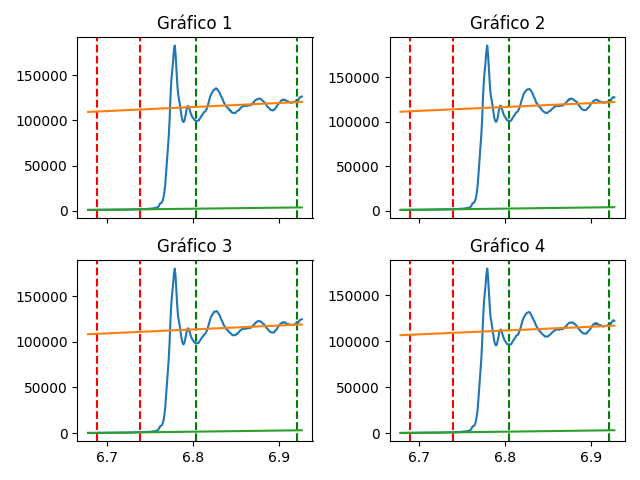

In [24]:
arq_1='B4_p40kp13_RT_1_A04062023_053631'
arq_2='B4_p40kp13_RT_3_A04062023_061749'
arq_3='B4_p40kp13_LT_1_A04062023_020113'
arq_4='B4_p40kp13_LT_3_A04062023_025315'

path='/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

c=Vortex(path+arq_1+'.csv', pos=[25,142], shift=-1000, n=2, m=2)
print(c.spectrum_params)
c.spectrum_params={'n':1,'m':1,'flattering':True}
print(c.spectrum_params)
c.plot_raw_data()
# c.plot_normalized()
# c.plot_derivative()
# print(c.name)
# print(c.legend)
# print(c.date)

# s=Spectrum(c.data['Energy'],c.data['roi21'], pos=[26,142], m=0)
# s.m=2
# s.n=3
# s.flattering=False
# s.update_params(m=1,n=1, pos=[50,120])
# s.plot_parameters()
# s.plot_normalized()



# Data visualization

{'pos': [31, 140], 'n': 2, 'm': 2}


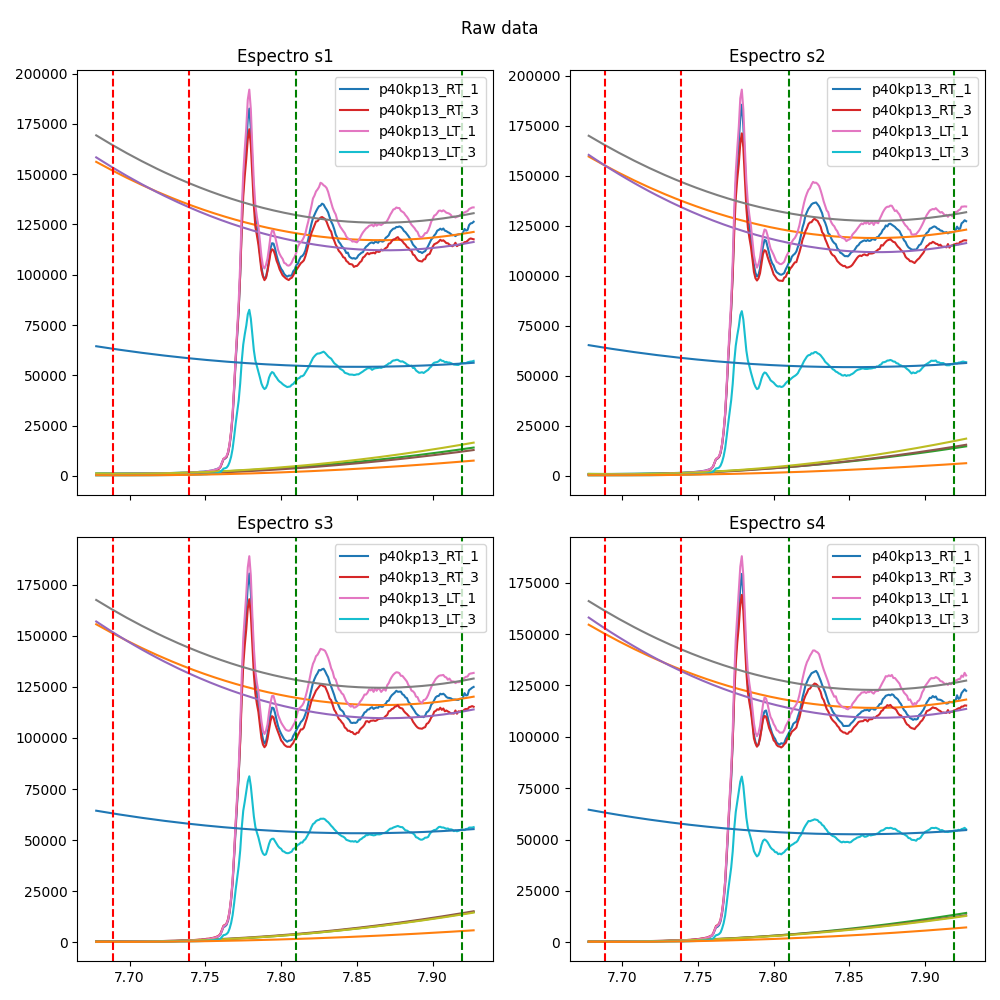

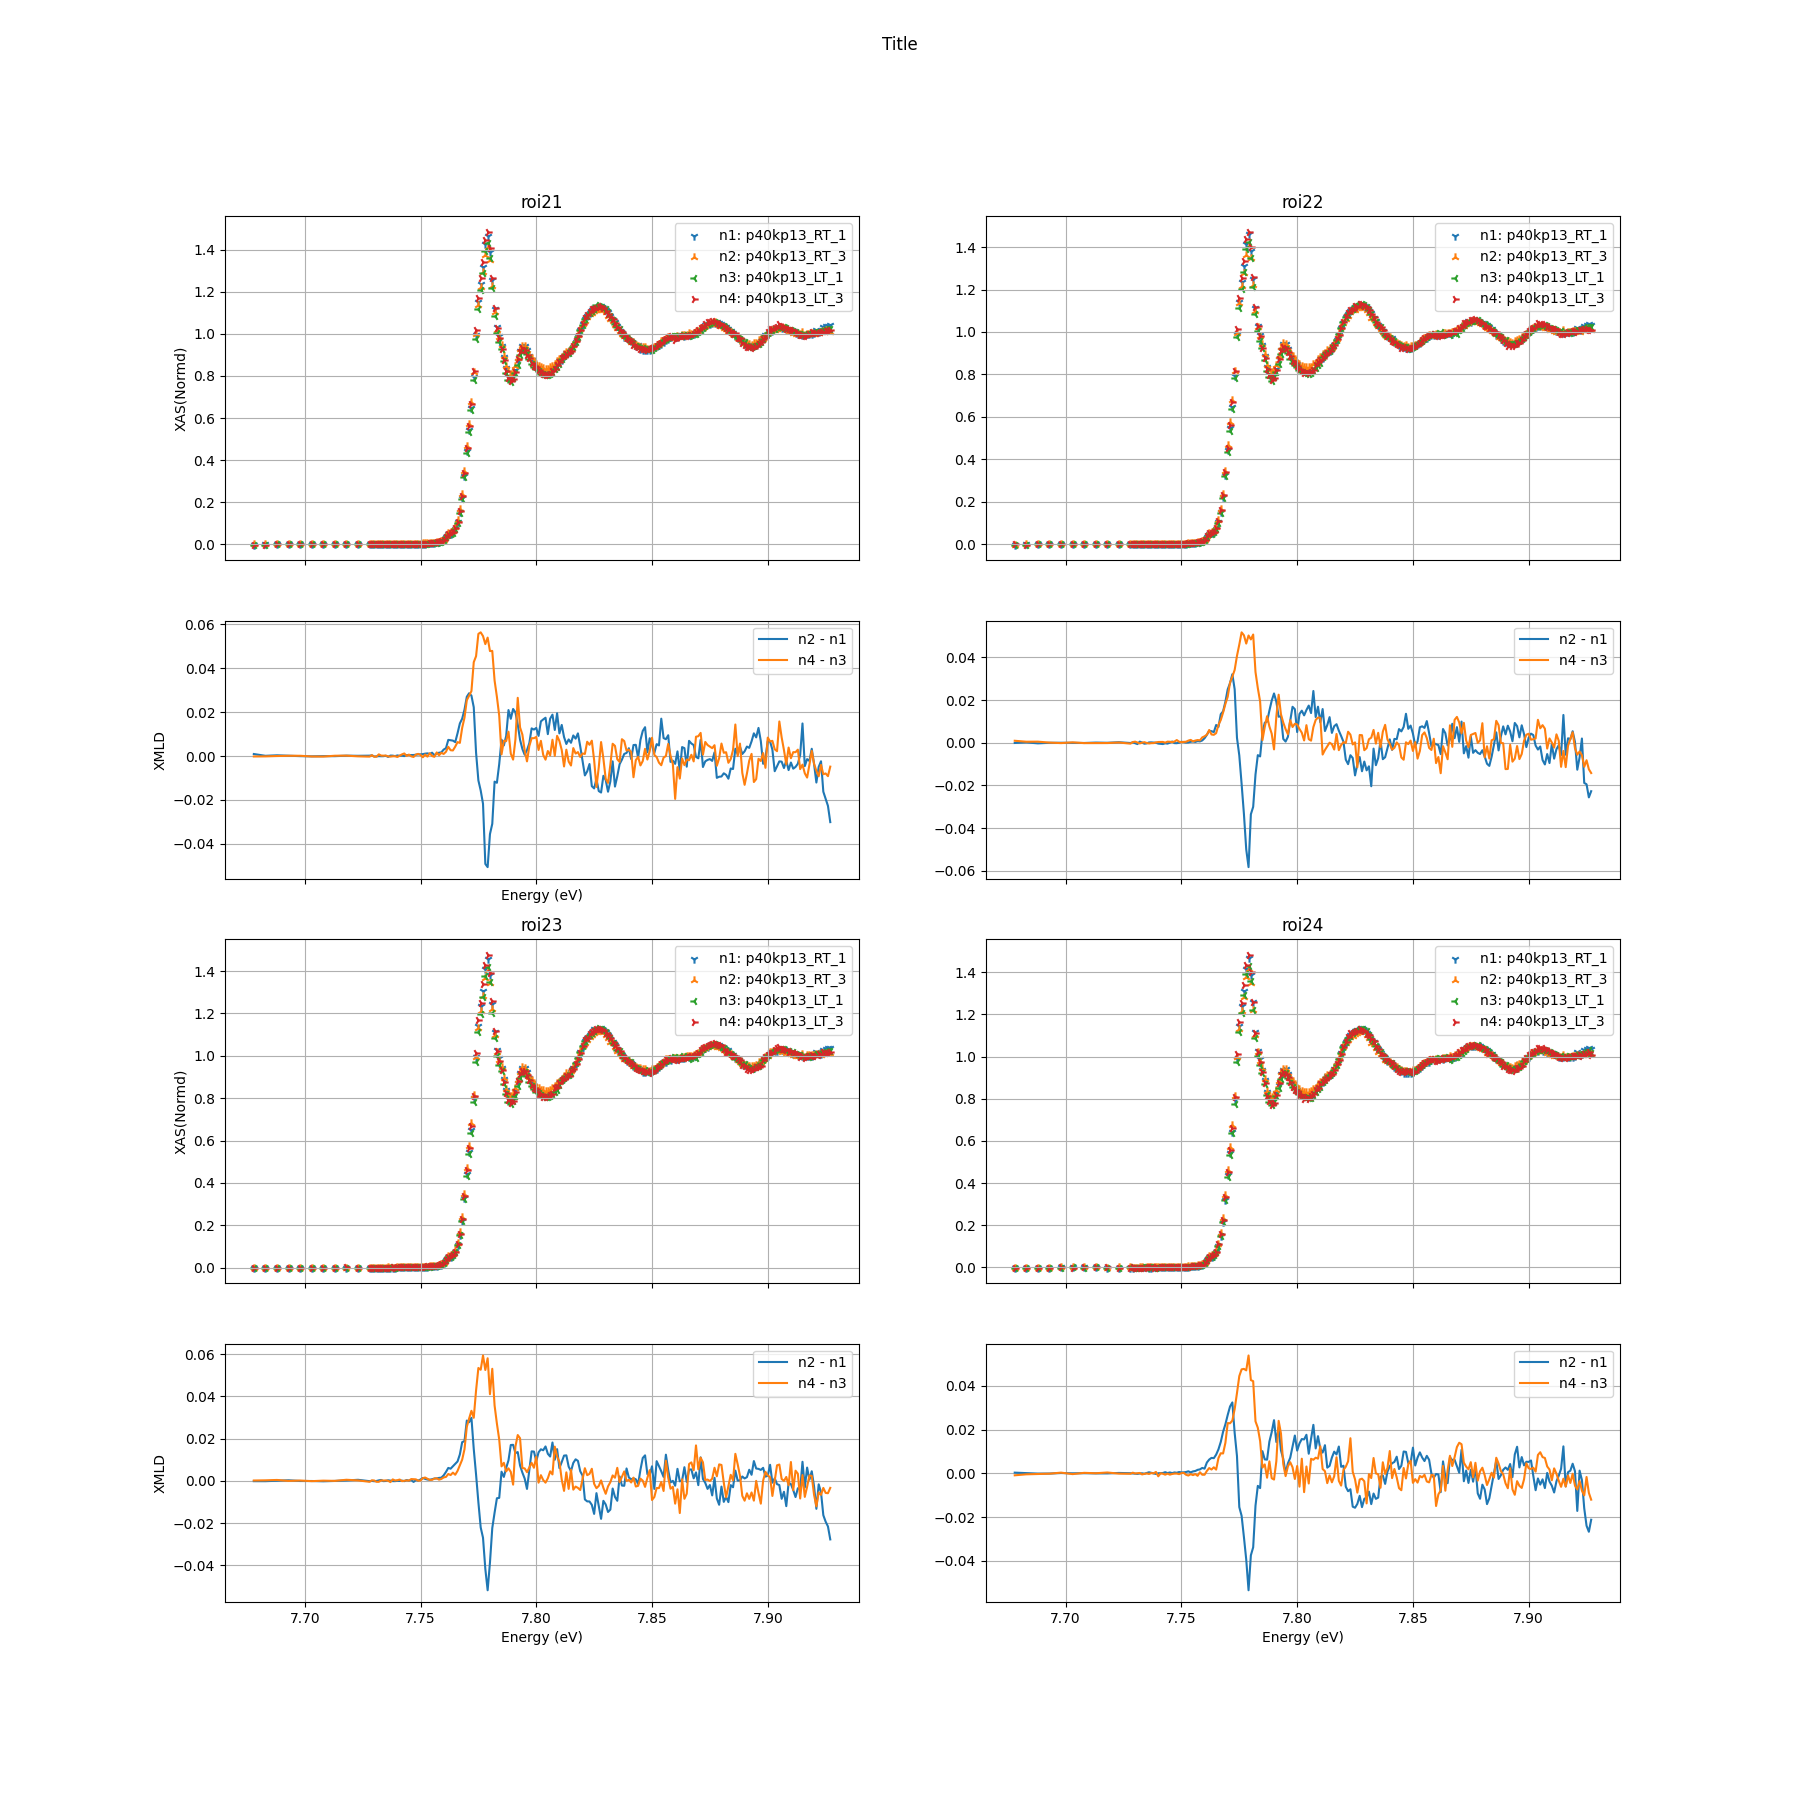

In [30]:
class xmld4:
    def __init__(self, arq1, arq2, arq3, arq4, title=None, **vortex_params):
        self.title = title
        self.vortex_params = vortex_params
        print(self.vortex_params)

        # Dados Brutos
        self.v1 = Vortex(arq1, **self.vortex_params)
        self.v2 = Vortex(arq2, **self.vortex_params)
        self.v3 = Vortex(arq3, **self.vortex_params)
        self.v4 = Vortex(arq4, **self.vortex_params)

        self.n1=self.v1
        self.n2=self.v2
        self.n3=self.v3
        self.n4=self.v4

        # Interpolação entre os dados
        self.n2.s1.update_params(x=self.n1.s1.x, y=np.interp(self.n1.s1.x, self.n2.s1.x, self.n2.s1.y))
        self.n2.s2.update_params(x=self.n1.s2.x, y=np.interp(self.n1.s2.x, self.n2.s2.x, self.n2.s2.y))
        self.n2.s3.update_params(x=self.n1.s3.x, y=np.interp(self.n1.s3.x, self.n2.s3.x, self.n2.s3.y))
        self.n2.s4.update_params(x=self.n1.s4.x, y=np.interp(self.n1.s4.x, self.n2.s4.x, self.n2.s4.y))

        self.n3.s1.update_params(x=self.n1.s1.x, y=np.interp(self.n1.s1.x, self.n3.s1.x, self.n3.s1.y))
        self.n3.s2.update_params(x=self.n1.s2.x, y=np.interp(self.n1.s2.x, self.n3.s2.x, self.n3.s2.y))
        self.n3.s3.update_params(x=self.n1.s3.x, y=np.interp(self.n1.s3.x, self.n3.s3.x, self.n3.s3.y))
        self.n3.s4.update_params(x=self.n1.s4.x, y=np.interp(self.n1.s4.x, self.n3.s4.x, self.n3.s4.y))

        self.n4.s1.update_params(x=self.n1.s1.x, y=np.interp(self.n1.s1.x, self.n4.s1.x, self.n4.s1.y))
        self.n4.s2.update_params(x=self.n1.s2.x, y=np.interp(self.n1.s2.x, self.n4.s2.x, self.n4.s2.y))
        self.n4.s3.update_params(x=self.n1.s3.x, y=np.interp(self.n1.s3.x, self.n4.s3.x, self.n4.s3.y))
        self.n4.s4.update_params(x=self.n1.s4.x, y=np.interp(self.n1.s4.x, self.n4.s4.x, self.n4.s4.y))

    def plot_rois(self):
        # Cria a figura e os subplots
        fig, axs = plt.subplots(4, 2, figsize=(18, 18), gridspec_kw={'height_ratios': [4, 3, 4, 3]}, sharex=True)
        fig.suptitle(self.title or 'Title')

        l = 0
        m = 0

        for i, ax in enumerate(axs.flatten()):

            if i == 0 or i == 1 or i == 4 or i == 5:
                if i == 0 or i == 4:
                    ax.set_ylabel('XAS(Normd)')
                ax.set_title(f'roi2{l+1}')

                # Definir os dados de espectro para o subplot
                x1, y1 = self.n1.spectra[l].x, self.n1.spectra[l].norm_y
                x2, y2 = self.n2.spectra[l].x, self.n2.spectra[l].norm_y
                x3, y3 = self.n3.spectra[l].x, self.n3.spectra[l].norm_y
                x4, y4 = self.n4.spectra[l].x, self.n4.spectra[l].norm_y

                # Plotar os dados
                ax.scatter(x1, y1, marker='1', label=f'n1: {self.n1.legend}')
                ax.scatter(x2, y2, marker='2', label=f'n2: {self.n2.legend}')
                ax.scatter(x3, y3, marker='3', label=f'n3: {self.n3.legend}')
                ax.scatter(x4, y4, marker='4', label=f'n4: {self.n4.legend}')

                ax.grid()
                ax.legend()
                l += 1

            elif i == 2 or i == 3 or i == 6 or i == 7:

                # Diferença entre os espectros
                diff1 = self.n2.spectra[m].norm_y - self.n1.spectra[m].norm_y
                diff2 = self.n4.spectra[m].norm_y - self.n3.spectra[m].norm_y

                ax.plot(self.n1.spectra[m].x, diff1, label='n2 - n1')
                ax.plot(self.n3.spectra[m].x, diff2, label='n4 - n3')

                if i == 6 or i == 7 or i == 2:
                    ax.set_xlabel('Energy (eV)')
                if i == 2 or i == 6:
                    ax.set_ylabel('XMLD')

                ax.grid()
                ax.legend()
                m += 1

    def plot(self):
        # Crie a figura e os eixos com ajuste de espaçamento vertical e proporções de altura
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        #plt.subplots_adjust(hspace=0)

        # Plote o primeiro gráfico
        ax1.scatter(self.n1.s.x, self.n1.s.norm_y,  marker='1', label=f'n1: {self.n1.legend}')
        ax1.scatter(self.n2.s.x, self.n2.s.norm_y,  marker='2', label=f'n2: {self.n2.legend}')
        ax1.scatter(self.n3.s.x, self.n3.s.norm_y,  marker='3', label=f'n3: {self.n3.legend}')
        ax1.scatter(self.n4.s.x, self.n4.s.norm_y,  marker='4', label=f'n4: {self.n4.legend}')
        ax1.grid()
        ax1.legend()
        ax1.set_ylabel('XAS (Normalizado)')


        # Plote o segundo gráfico no mesmo eixo
        ax2.plot(self.n1.s.x,self.n2.s.norm_y-self.n1.s.norm_y, label='n2-n1')
        ax2.plot(self.n3.s.x,self.n4.s.norm_y-self.n3.s.norm_y, label='n4-n3')
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel('Energia (eV)')
        ax2.set_ylabel('XMLD')


        # Exiba o gráfico
        plt.tight_layout()

        plt.show()

    def plot_parameters(self, **kwargs):
        """
        Plota 4 gráficos, dois em cima e dois em baixo.
        Cada gráfico plota espectros equivalentes (s1, s2, s3, s4) de cada classe Vortex.
        """
        fig, axs = plt.subplots(2, 2, sharex=True, **kwargs)
        fig.suptitle('Raw data')

        # Nomes dos espectros e títulos dos subplots
        spectra = ['s1', 's2', 's3', 's4']
        titles = ['Espectro s1', 'Espectro s2', 'Espectro s3', 'Espectro s4']

        # Itera sobre os subplots e os espectros
        for idx, (ax, spectrum, title) in enumerate(zip(axs.flat, spectra, titles)):
            for n in [self.n1, self.n2, self.n3, self.n4]:
                # Obter o espectro atual (s1, s2, etc.) para o objeto Vortex (n)
                spec = getattr(n, spectrum)
                ax.plot(spec.x, spec.y, label=f'{n.legend}')
                ax.plot(spec.x, spec.f(spec.x))
                ax.plot(spec.x, spec.p(spec.x))

            # Adiciona as linhas verticais baseadas nos valores de `pre` e `pos` do espectro `s1` de `n1`
            base_spec = getattr(self.n1, spectrum)
            ax.axvline(x=base_spec.E0 + base_spec.pre[0] / 1000, color='r', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pre[1] / 1000, color='r', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pos[0] / 1000, color='g', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pos[1] / 1000, color='g', linestyle='--')

            ax.set_title(title)
            ax.legend()

        plt.tight_layout()
        plt.show()





# Exemplo de uso
arq1 = 'B4_p40kp13_RT_1_A04062023_053631'
arq2 = 'B4_p40kp13_RT_3_A04062023_061749'
arq3 = 'B4_p40kp13_LT_1_A04062023_020113'
arq4 = 'B4_p40kp13_LT_3_A04062023_025315'

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

# Instanciando e plotando
a = xmld4(path + arq1 + '.csv', path + arq2 + '.csv', path + arq3 + '.csv', path + arq4 + '.csv', pos=[31,140],n=2, m=2)
a.plot_parameters( figsize=(10, 10))
a.plot_rois()
#a.plot()

In [ ]:
# prompt: Quero fazer uma função que gere uma figura usando matplotlib . A função recebe um numero n de classes axmld4. A função deve plotar o mesmo padrão de xmld4.plot() porém para cada plot de xmld4 deve haver um parametro organize um deslocamento vertical entre os plots

def plot_multiple_xmld4(xmld4_list, vertical_shift=0.1):
  """
  Plota vários objetos xmld4 em um único gráfico com deslocamento vertical.

  Args:
    xmld4_list: Uma lista de objetos xmld4 a serem plotados.
    vertical_shift: O valor do deslocamento vertical entre os plots.
  """

  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

  for i, xmld4_obj in enumerate(xmld4_list):
    # Deslocamento vertical para cada plot
    y_shift = i * vertical_shift

    # Plota XAS normalizado no primeiro eixo
    ax1.scatter(xmld4_obj.n1.s.x, xmld4_obj.n1.s.norm_y + y_shift, marker='1', label=f'n1: {xmld4_obj.n1.legend}:{xmld4_obj.n1.date}')
    ax1.scatter(xmld4_obj.n2.s.x, xmld4_obj.n2.s.norm_y + y_shift, marker='2', label=f'n2: {xmld4_obj.n2.legend}:{xmld4_obj.n2.date}')
    ax1.scatter(xmld4_obj.n3.s.x, xmld4_obj.n3.s.norm_y + y_shift, marker='3', label=f'n3: {xmld4_obj.n3.legend}:{xmld4_obj.n3.date}')
    ax1.scatter(xmld4_obj.n4.s.x, xmld4_obj.n4.s.norm_y + y_shift, marker='4', label=f'n4: {xmld4_obj.n4.legend}:{xmld4_obj.n4.date}')


    # Plota XMLD no segundo eixo
    ax2.plot(xmld4_obj.n1.s.x, (xmld4_obj.n2.s.norm_y - xmld4_obj.n1.s.norm_y) + y_shift, label=f'n2-n1: {xmld4_obj.n2.legend}')
    ax2.plot(xmld4_obj.n3.s.x, (xmld4_obj.n4.s.norm_y - xmld4_obj.n3.s.norm_y) + y_shift, label=f'n4-n3: {xmld4_obj.n4.legend}')

  ax1.grid()
  ax1.legend()
  ax1.set_ylabel('XAS (Normalizado)')

  ax2.legend()
  ax2.grid()
  ax2.set_xlabel('Energia (eV)')
  ax2.set_ylabel('XMLD')

  plt.tight_layout()
  plt.show()



In [ ]:
# # Exemplo de uso

# path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

# arq1 = 'B4_p40kp13_RT_1_A04062023_053631.csv'
# arq2 = 'B4_p40kp13_RT_3_A04062023_061749.csv'
# arq3 = 'B4_p40kp13_LT_1_A04062023_015121.csv'
# arq4 = 'B4_p40kp13_LT_3_A04062023_025315.csv'

# a = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)

# arq1 = 'B4_p40kp13_RT_1_A04062023_054503.csv'
# arq2 = 'B4_p40kp13_RT_3_A04062023_062621.csv'
# arq3 = 'B4_p40kp13_LT_1_A04062023_020113.csv'
# arq4 = 'B4_p40kp13_LT_3_A04062023_024209.csv'

# b = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)


# # Instanciando e plotando

# plot_multiple_xmld4([a, b])